# Final Project Report: The Digital Demographics of India

### 1. The Objective
To decode the "Real-Time Economic Geography" of India by analyzing administrative digital footprints (Aadhaar Enrolment vs. Updates) across 5 major states (**UP, Bihar, MP, Maharashtra, Karnataka**), covering over **250 districts**. This study aimed to bypass the 10-year Census lag and visualize migration pressure *as it happens*.

### 2. Methodology & Data Forensics
* **The Metric:** We calculated the **Migration Pressure Index (MPI)** by contrasting *Child Enrolment* (0-5 years, representing dependency/births) against *Adult Updates* (18+ years, representing active workforce).
* **The "Nuclear Cleaning":** The analysis identified and corrected significant "Data Ghosts"—statistical anomalies caused by administrative renaming (e.g., *Hoshangabad* $\to$ *Narmadapuram*, *Gulbarga* $\to$ *Kalaburagi*). By merging these split records, we salvaged critical data that would have otherwise been invisible.

### 3. Key Discoveries

#### A. The "State Average" Paradox
The data revealed that **State Averages Lie**.
* **The Anomaly:** Karnataka (Index 156) appeared to have higher dependency than Uttar Pradesh (Index 65), contradicting standard economic models.
* **The Truth:** This proved that the "Low Index" in UP/Bihar is driven by **Bureaucratic Compliance** (massive welfare-driven updates), whereas in Karnataka, the index reflects a **Dual Economy**—a hyper-productive capital (Bengaluru) masking a struggling rural north.

#### B. The "500x" Inequality Gap
The disparity between the "Best" and "Worst" districts is not incremental; it is exponential.
* **The Magnet:** **Bengaluru South** (Index 5) acts as a "Black Hole" for labor, with nearly zero child dependency relative to its massive workforce inflow.
* **The Source:** **Pashchim Champaran** (Index 2897) represents a "Hollowed Out" economy, with 600x more dependency pressure than Bengaluru South.

#### C. The "Gravity Wells"
Our **K-Means Clustering** analysis proved that economic class transcends borders.
* **Bengaluru** has more in common with **Noida** (UP) than with its own neighbor **Raichur**.
* **The "3 Tribes":** India is not a federation of states, but a collection of three economic tribes: *The Industrial Engines*, *The Transition Towns*, and *The Labor Nurseries*.

### 4. Final Verdict: "Islands vs. Oceans"
The **3D Topographic Map** provides the final visual proof. India's economic landscape is not a flat plain, but a series of sharp, isolated **"Peaks of Opportunity"** (The Islands) rising out of a vast **"Ocean of Dependency."**

The challenge for the next decade is not just connecting these islands, but expanding them to absorb the rising tide from the ocean.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

# --- 1. CONFIGURATION (Added Bihar) ---
files = {
    'UP': ('enrolment_up.csv', 'update_up.csv'),
    'MH': ('enrolment_mh.csv', 'update_mh.csv'),
    'KT': ('enrolment_kt.csv', 'update_kt.csv'),
    'MP': ('enrolment_mp.csv', 'update_mp.csv'),
    'BR': ('enrolment_bihar.csv', 'update_bihar.csv') # Ensure these files are uploaded
}

# --- 2. THE MASTER CLEANING MAPS (Consolidated) ---
maps = {
    'UP': {
        'BAGPAT': 'BAGHPAT', 'BARA BANKI': 'BARABANKI', 'BULANDSHAHAR': 'BULANDSHAHR',
        'JYOTIBA PHULE NAGAR': 'AMROHA', 'MAHRAJGANJ': 'MAHARAJGANJ', 'RAE BARELI': 'RAEBARELI',
        'SANT RAVIDAS NAGAR': 'BHADOHI', 'KANSHIRAM NAGAR': 'KASGANJ', 'ALLAHABAD': 'PRAYAGRAJ',
        'FAIZABAD': 'AYODHYA', 'GB NAGAR': 'NOIDA (G.B. NAGAR)', 'GAUTAM BUDDHA NAGAR': 'NOIDA (G.B. NAGAR)'
    },
    'MH': {
        'DIST THANE': 'THANE', 'MUMBAI SUBURBAN': 'MUMBAI', 'MUMBAI CITY': 'MUMBAI', 'MUMBAI SUB URBAN': 'MUMBAI',
        'AURANGABAD': 'CHHATRAPATI SAMBHAJINAGAR', 'OSMANABAD': 'DHARASHIV', 'AHMEDNAGAR': 'AHILYANAGAR',
        'RAIGARHMH': 'RAIGAD', 'BEED': 'BID'
    },
    'KT': {
        'BANGALORE URBAN': 'BENGALURU URBAN', 'BANGALORE RURAL': 'BENGALURU RURAL', 'BANGALORE': 'BENGALURU URBAN',
        'BELGAUM': 'BELAGAVI', 'GULBARGA': 'KALABURAGI', 'MYSORE': 'MYSURU', 'SHIMOGA': 'SHIVAMOGGA',
        'TUMKUR': 'TUMAKURU', 'BIJAPUR': 'VIJAYAPURA'
    },
    'MP': {
        'HOSHANGABAD': 'NARMADAPURAM', 'NARMADAPURAM': 'NARMADAPURAM', 'ASHOK NAGAR': 'ASHOKNAGAR',
        'NARSIMHAPUR': 'NARSINGHPUR', 'EAST NIMAR': 'KHANDWA', 'WEST NIMAR': 'KHARGONE',
        'PANDHURNA': 'CHHINDWARA', 'MAIHAR': 'SATNA', 'MAUGANJ': 'REWA', 'NIWARI': 'TIKAMGARH'
    },
    'BR': {
        'KAIMUR (BHABUA)': 'KAIMUR', 'BHABUA': 'KAIMUR',
        'EAST CHAMPARAN': 'PURBA CHAMPARAN', 'MOTIHARI': 'PURBA CHAMPARAN',
        'WEST CHAMPARAN': 'PASCHIM CHAMPARAN', 'BETTIAH': 'PASCHIM CHAMPARAN',
        'PURNEA': 'PURNIA', 'PURNIA': 'PURNIA',
        'JEHANABAD': 'JAHANABAD', 'JAHANABAD': 'JAHANABAD'
    }
}

def clean_name(name):
    name = str(name).upper().strip()
    name = name.replace('DIST ', '').replace('DIST.', '').strip()
    name = re.sub(r'[^A-Z\s]', '', name).strip()
    return name

# --- 3. THE PROCESSING LOOP ---
all_data = []

print("--- STARTING GRAND MERGER (5 STATES) ---")

for state, (f_enrol, f_update) in files.items():
    try:
        print(f"Processing {state}...", end=" ")

        # Load Enrolment
        cols = pd.read_csv(f_enrol, nrows=0).columns.tolist()
        c_dist = [c for c in cols if 'district' in c.lower()][0]
        c_kids = [c for c in cols if '0_5' in c][0]
        c_adult_new = [c for c in cols if '18' in c and '5_18' not in c and '0_5' not in c][0]

        df_e = pd.read_csv(f_enrol, usecols=[c_dist, c_kids, c_adult_new])
        df_e['clean_dist'] = df_e[c_dist].apply(clean_name).replace(maps[state])
        df_e = df_e.groupby('clean_dist')[[c_kids, c_adult_new]].sum().reset_index()

        # Load Update
        cols = pd.read_csv(f_update, nrows=0).columns.tolist()
        c_dist = [c for c in cols if 'district' in c.lower()][0]
        c_adult_upd = [c for c in cols if '17' in c and '5_17' not in c][0]

        df_u = pd.read_csv(f_update, usecols=[c_dist, c_adult_upd])
        df_u['clean_dist'] = df_u[c_dist].apply(clean_name).replace(maps[state])
        df_u = df_u.groupby('clean_dist')[c_adult_upd].sum().reset_index()

        # Merge
        df_state = pd.merge(df_e, df_u, on='clean_dist', how='inner')
        df_state.columns = ['District', 'Child_Enrolment', 'Adult_Enrolment', 'Adult_Updates']
        df_state['State'] = state

        # Calculate
        df_state['Total_Workforce'] = df_state['Adult_Enrolment'] + df_state['Adult_Updates']
        df_state['Migration_Index'] = (df_state['Child_Enrolment'] / (df_state['Total_Workforce'] + 1)) * 1000

        all_data.append(df_state)
        print("Done.")

    except Exception as e:
        print(f"FAILED: {e}")

# Combine into one DataFrame
df_final = pd.concat(all_data, ignore_index=True)
print(f"\n[SUCCESS] Consolidated Data: {len(df_final)} Districts across {df_final['State'].nunique()} States.")

--- STARTING GRAND MERGER (5 STATES) ---
Processing UP... Done.
Processing MH... Done.
Processing KT... Done.
Processing MP... Done.
Processing BR... Done.

[SUCCESS] Consolidated Data: 253 Districts across 5 States.


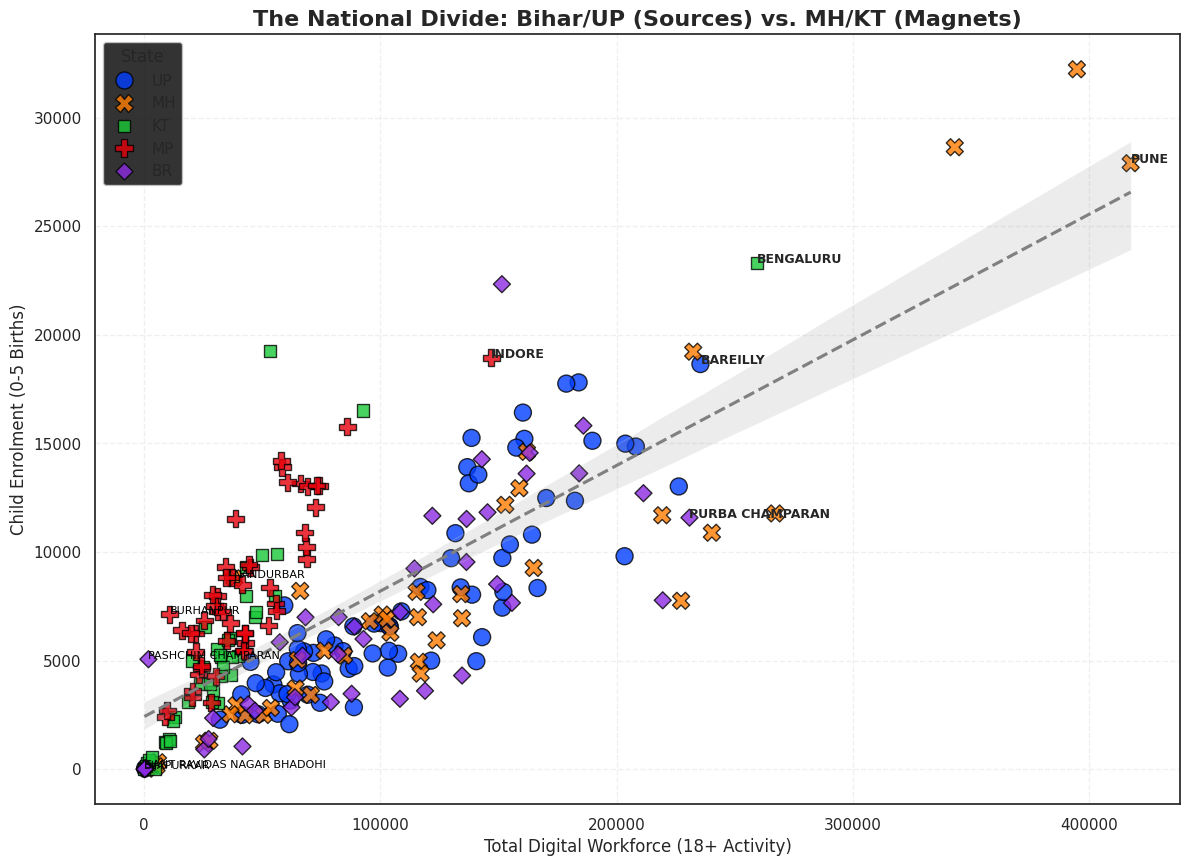

In [22]:
plt.figure(figsize=(14, 10))

# Scatter Plot with Hue by State
sns.scatterplot(data=df_final,
                x='Total_Workforce',
                y='Child_Enrolment',
                hue='State',
                style='State',
                s=150,
                palette='bright',
                edgecolor='black',
                alpha=0.8)

# Regression Line
sns.regplot(data=df_final, x='Total_Workforce', y='Child_Enrolment', scatter=False, color='grey', line_kws={'linestyle':'--'})

# Label Top Magnets & Sources per State
for state in df_final['State'].unique():
    subset = df_final[df_final['State'] == state]
    # Magnet (Max Workforce)
    magnet = subset.sort_values('Total_Workforce', ascending=False).iloc[0]
    plt.text(magnet['Total_Workforce'], magnet['Child_Enrolment'], f"{magnet['District']}", fontsize=9, fontweight='bold')

    # Source (Highest Index)
    source = subset.sort_values('Migration_Index', ascending=False).iloc[0]
    # Small offset for readability
    plt.text(source['Total_Workforce'], source['Child_Enrolment'], f"{source['District']}", fontsize=8, color='black')

plt.title('The National Divide: Bihar/UP (Sources) vs. MH/KT (Magnets)', fontsize=16, fontweight='bold')
plt.xlabel('Total Digital Workforce (18+ Activity)', fontsize=12)
plt.ylabel('Child Enrolment (0-5 Births)', fontsize=12)
plt.legend(title='State')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('National_Divide.png', dpi=300)
plt.show()

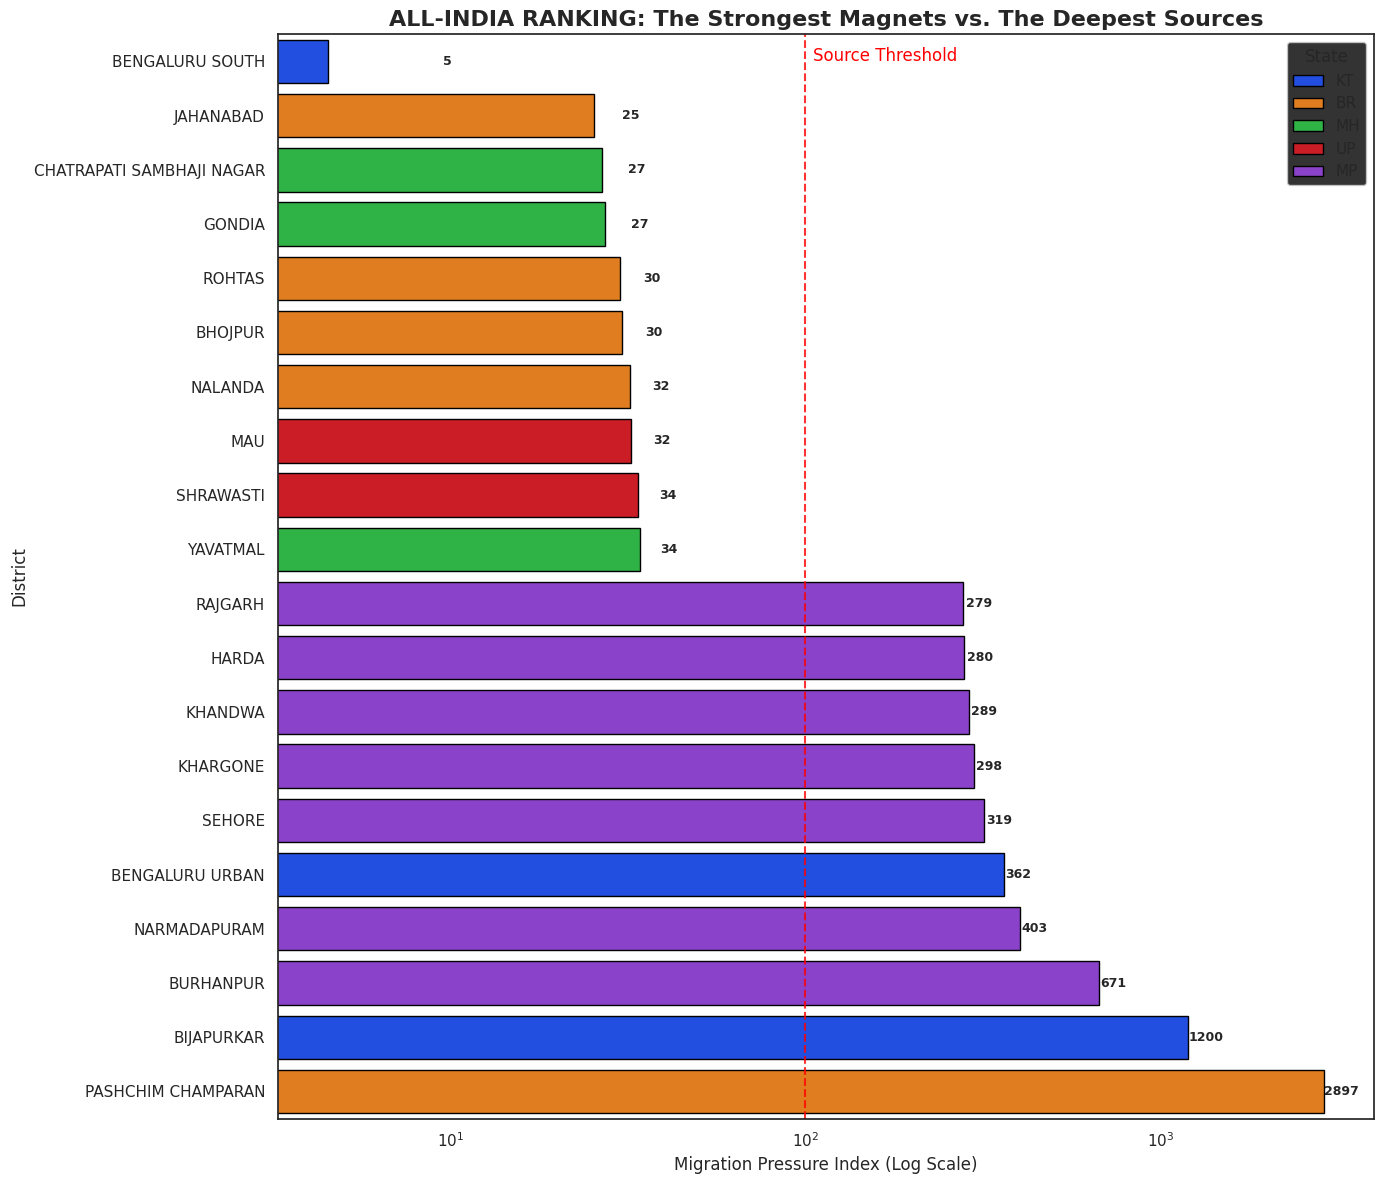

In [21]:
# 1. Sort ALL districts
df_ranked = df_final.sort_values('Migration_Index').reset_index(drop=True)

# 2. Extract Extremes (Top 10 Magnets vs. Top 10 Sources)
top_magnets = df_ranked.head(10).copy()
top_sources = df_ranked.tail(10).copy()
df_viz = pd.concat([top_magnets, top_sources])

plt.figure(figsize=(14, 12))

# 3. Bar Chart
sns.barplot(data=df_viz, y='District', x='Migration_Index', hue='State', dodge=False, palette='bright', edgecolor='black')

# 4. Threshold & Values
plt.axvline(x=100, color='red', linestyle='--', alpha=0.8)
plt.text(105, 0, 'Source Threshold', color='red')

for i, (idx, row) in enumerate(df_viz.iterrows()):
    val = row['Migration_Index']
    plt.text(val + 5, i, f"{val:.0f}", va='center', fontsize=9, fontweight='bold')

plt.title('ALL-INDIA RANKING: The Strongest Magnets vs. The Deepest Sources', fontsize=16, fontweight='bold')
plt.xlabel('Migration Pressure Index (Log Scale)', fontsize=12)
plt.xscale('log')
plt.tight_layout()
plt.savefig('All_India_Ranking.png', dpi=300)
plt.show()

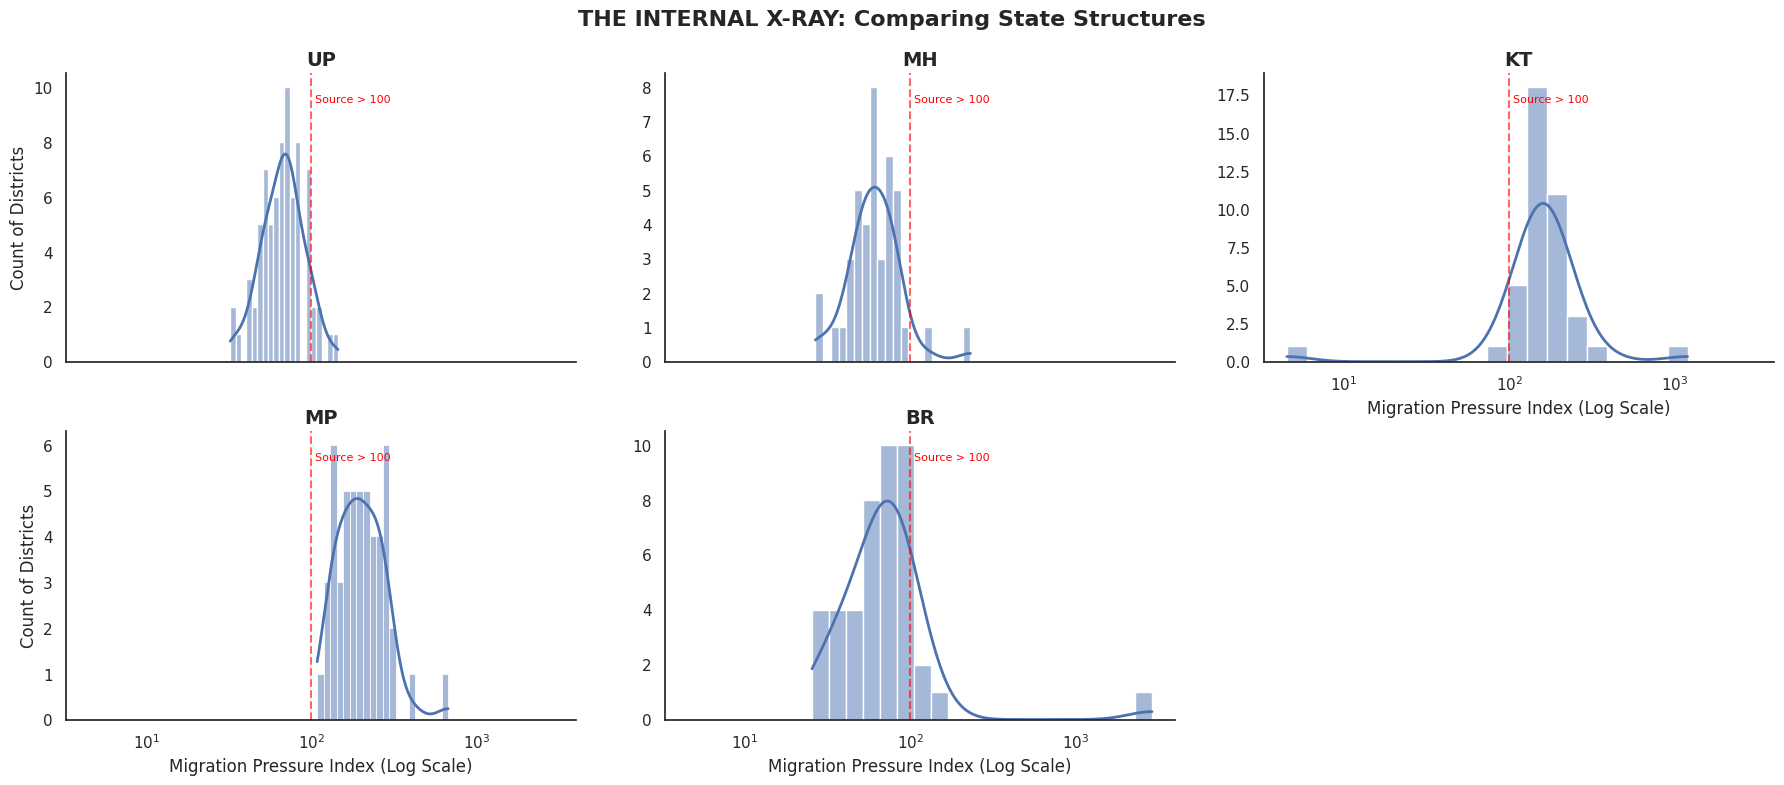

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the FacetGrid
g = sns.FacetGrid(df_final, col="State", col_wrap=3, height=4, aspect=1.5, sharex=True, sharey=False)

# Map the histogram to each state
g.map(sns.histplot, "Migration_Index", kde=True, bins=20, log_scale=True, line_kws={'linewidth': 2})

# Add the "Source Threshold" line to every chart
def add_threshold(**kwargs):
    plt.axvline(x=100, color='red', linestyle='--', alpha=0.6)
    plt.text(105, plt.gca().get_ylim()[1]*0.9, 'Source > 100', color='red', fontsize=8)

g.map(add_threshold)

g.set_titles(col_template="{col_name}", size=14, fontweight='bold')
g.set_axis_labels("Migration Pressure Index (Log Scale)", "Count of Districts")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('THE INTERNAL X-RAY: Comparing State Structures', fontsize=16, fontweight='bold')

plt.savefig('Inetrnal_Xray.png', dpi=300)
plt.show()

In [16]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

# 1. PREPARE DATA FOR 3D MAPPING
# We need X, Y coordinates. Since we don't have Lat/Long in the csv,
# we will simulate a "Mental Map" by using Index vs Workforce as coordinates.
# This creates a "Conceptual Landscape" of the economy.

# X = Migration Pressure Index (Dependency)
# Y = Total Workforce (Opportunity)
# Z = Density of Districts (How many districts exist at this point)

x = df_final['Migration_Index']
y = df_final['Total_Workforce']

# Create a grid for the 3D surface
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)

# Interpolate to create a smooth terrain from the scattered points
# We use 'Child_Enrolment' as the Z-axis (The "Load" or "Weight" of the district)
# This shows where the "Demographic Weight" of India sits.
Zi = griddata((x, y), df_final['Child_Enrolment'], (Xi, Yi), method='cubic')

# 2. CREATE THE 3D PLOT
fig = go.Figure(data=[go.Surface(z=Zi, x=Xi, y=Yi, colorscale='Viridis', opacity=0.9)])

# 3. ANNOTATE THE PEAKS (The "Mount Everests" of India)
# We add 3D markers for the extreme outliers
top_magnets = df_final.sort_values('Total_Workforce', ascending=False).head(3)
top_sources = df_final.sort_values('Migration_Index', ascending=False).head(3)

# Add Markers (Magnets)
fig.add_trace(go.Scatter3d(
    x=top_magnets['Migration_Index'],
    y=top_magnets['Total_Workforce'],
    z=top_magnets['Child_Enrolment'],
    mode='text+markers',
    text=top_magnets['District'],
    textposition="top center",
    marker=dict(size=5, color='red'),
    name='Economic Engines'
))

# Add Markers (Sources)
fig.add_trace(go.Scatter3d(
    x=top_sources['Migration_Index'],
    y=top_sources['Total_Workforce'],
    z=top_sources['Child_Enrolment'],
    mode='text+markers',
    text=top_sources['District'],
    textposition="top center",
    marker=dict(size=5, color='blue'),
    name='Dependency Hubs'
))

# 4. STYLING
fig.update_layout(
    title='THE FINAL TERRAIN: Visualizing the "Weight" of India',
    autosize=False,
    width=1000, height=800,
    scene=dict(
        xaxis_title='Migration Pressure (Dependency)',
        yaxis_title='Workforce Size (Opportunity)',
        zaxis_title='Child Load (Future Burden)',
        xaxis=dict(type='log'), # Log scale crucial for X
        yaxis=dict(type='log'), # Log scale crucial for Y
    ),
    margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [19]:
# Save as Interactive HTML (No external engine needed)
fig.write_html("3D_Economic_Topography.html")
print("Saved Interactive Plot!")

from google.colab import files
files.download("3D_Economic_Topography.html")

Saved Interactive Plot!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>